# Análise dos dados de  scRNA-seq:  
# DIFERENTIAL EXPRESSED GENES ANALYSIS

> **Ambiente:** 
> - scrnaseq-workflow
> - scRNA_NEW

# Differential Expression Analysis (DEGs) — Overview


This notebook performs **cell-type–resolved differential gene expression analysis** using **MAST**, comparing two experimental conditions (e.g. WT vs KO) within each annotated cell type.

### Workflow summary

1. **Data preparation**
   - Load the annotated and QC-filtered AnnData object.
   - Select the appropriate expression layer (e.g. `QC_filtered`).
   - Define biological replicates and experimental labels.
   - Apply minimal filtering on cells and genes to ensure robust statistics.

2. **Cell-type–specific DEG analysis**
   - For each cell type, cells are subsetted and analyzed independently.
   - MAST is run with:
     - Condition as the main contrast (e.g. WT vs KO),
     - Optional replicate information (random effect),
     - Gene frequency filtering,
     - Multiple-testing correction (FDR).
   - Cell types with insufficient numbers of cells per group are automatically skipped.

3. **Result aggregation**
   - DEG results are stored per cell type.
   - All valid results can be exported into a single consolidated table for downstream analyses.

4. **Visualization**
   - **Volcano plots** per cell type highlight significantly up- and down-regulated genes.
   - **Bar plots** show the top DEGs (by FDR and log2FC) for each cell type.
   - **Heatmaps** summarize log2FC patterns of top DEGs across cell types, enabling direct comparison of transcriptional responses.


# FUNCTIONS AND PACKS

In [4]:
# --------------------------------------
# Suppress Warnings and Set Logging
# --------------------------------------
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("rpy2").setLevel(logging.ERROR)

# --------------------------------------
# Python Imports
# --------------------------------------
from scipy import sparse
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import anndata2ri
import sc_toolbox  # seu módulo
import math

# --------------------------------------
# Configure Scanpy (sem recursão)
# --------------------------------------
sc.settings.verbosity = 0
# Em vez de sc.settings.set_figure_params(...):
mpl.rcParams.update({
    "figure.dpi": 100,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})
# (opcional) estilo com grid leve, parecido com o padrão do Scanpy:
sns.set_style("whitegrid")

# --------------------------------------
# RPy2: conversão e pacotes (sem %R magic)
# --------------------------------------
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import rpy2.rinterface_lib.callbacks as rcb
from rpy2.robjects import globalenv, default_converter
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter
from anndata2ri import converter

# Ativa conversores (global é ok; para uso cirúrgico, use 'with localconverter(...)')
pandas2ri.activate()
numpy2ri.activate()
anndata2ri.activate()
PY2R_CONVERTER = default_converter + pandas2ri.converter + numpy2ri.converter + converter

# --------------------------------------
# Carregar pacotes R de forma silenciosa
# --------------------------------------
def r_suppress_library(pkg):
    try:
        ro.r(f'suppressMessages(library({pkg}))')
        return True
    except Exception as e:
        print(f"Aviso: pacote R '{pkg}' não foi carregado. ({e})")
        return False

r_suppress_library("SingleCellExperiment")
r_suppress_library("MAST")



True

## Import and Export

In [ ]:
def Import4DEGs(input_h5,
                entry_layer="counts",
                map_replicate=None,          # e.g.: {'87':'1','88':'1','89':'2','90':'2'}
                filter_by=None, filter_what=None,
                min_genes_by_cell=200, min_cells_by_gene=3):
    
    # Load AnnData object from disk
    adata = sc.read(input_h5)

    # Optional filtering by an .obs column (e.g., tissue, condition, cell type)
    if filter_by is not None and filter_what is not None and filter_by in adata.obs:
        adata = adata[adata.obs[filter_by].astype(str) == str(filter_what)].copy()

    # Use the specified layer as the main expression matrix (.X), if it exists
    if entry_layer in adata.layers:
        adata.X = adata.layers[entry_layer].copy()

    # Create a 'replicate' column from 'sample' using a provided mapping
    # This is useful for pseudobulk or DE methods that require biological replicates
    if map_replicate is not None and 'sample' in adata.obs:
        s = adata.obs['sample'].astype(str)
        adata.obs['replicate'] = pd.Categorical(s.map(map_replicate))

    # Basic QC-style filtering for DEG analysis
    # Remove low-quality cells with few detected genes
    sc.pp.filter_cells(adata, min_genes=min_genes_by_cell)
    # Remove genes expressed in very few cells
    sc.pp.filter_genes(adata, min_cells=min_cells_by_gene)

    return adata


In [ ]:
## EXPORT ALL RESULTS TOGETHER (including a column identifying cell types)
# Function to aggregate DEG results across cell types and export them as a single CSV
def ExportCSVTogether(dic_results, parameters, sufix=''):
    all_results = []

    # Build output file name encoding the main analysis parameters
    output_file = (
        f"degs_MAST_{parameters['filter_what']}"
        f"_FF{parameters['freq_filter']}"
        f"_FDR{parameters['fdr_filter']}"
        f"_RandomEffect{parameters['random_effect']}"
        f"{sufix}.csv"
    )

    # Collect only valid DEG result tables (DataFrames)
    for cell_type, res in dic_results.items():
        if isinstance(res, pd.DataFrame):  # Ensure the result is a DataFrame
            all_results.append(res)

    # Concatenate all DEG tables into a single DataFrame
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)

        # Export combined results to disk
        combined_df.to_csv(
            output_file,
            index=False,
            sep='\t'
        )
        print("All DEG results were successfully saved into a single file.")
    else:
        print("No DEG results available to export.")

    return combined_df


## MAST

In [ ]:
def apply_MAST(adata, cell_type,
                label_col = "label",
                cell_type_col = "cell_type",
                replicate_col = "replicate",
                ref_level = "wild",
                contrast_level = "knockout",
                freq_filter = 0.1,
                fdr_filter = 0.01,
                random_effect = True):
    
    # Transfer the AnnData object from Python to the R environment
    # using rpy2 local conversion
    with localconverter(converter):
        globalenv["adata"] = adata

    # Define analysis parameters in the R global environment
    ro.globalenv['cell_type'] = cell_type
    ro.globalenv['label_col'] = label_col
    ro.globalenv['celltype_col'] = cell_type_col    
    ro.globalenv['replicate_col'] = replicate_col
    ro.globalenv['ref_level'] = ref_level
    ro.globalenv['contrast_level'] = contrast_level
    ro.globalenv['freq_filter'] = freq_filter
    ro.globalenv['fdr_filter'] = fdr_filter
    ro.globalenv['random_effect'] = random_effect  # whether to include random effects

    # Define the R function that performs DEG analysis using MAST
    ro.r("""
        find_de_MAST_RE <- function(adata_mono, cell_type,
                                label_col, 
                                celltype_col, 
                                replicate_col, 
                                ref_level,
                                contrast_level,
                                freq_filter, 
                                fdr_filter,
                                random_effect) {
        library(MAST)

        # Report filtering thresholds
        cat("Frequency filter:", freq_filter, "\\n", "FDR filter:", fdr_filter, "\\n")
         
        # Convert AnnData to SingleCellAssay object
        sca <- SceToSingleCellAssay(adata_mono, class = "SingleCellAssay")
        print("Dimensions before subsetting:")
        print(dim(sca))
        print("")
        
        # Filter genes based on detection frequency
        sca <- sca[freq(sca) > freq_filter, ]
        print("Dimensions after subsetting:")
        print(dim(sca))
        print("")
        
        # Compute and scale the number of detected genes per cell
        cdr2 <- colSums(assay(sca) > 0)
        colData(sca)$ngeneson <- scale(cdr2)
        
        # Define condition labels and set reference level
        label <- factor(colData(sca)[[label_col]])
        label <- relevel(label, ref_level)
        colData(sca)[[label_col]] <- label
         
        # Check levels after releveling
        cat("Levels of 'label' after relevel(label, ref_level):\\n")
        print(levels(label))
        
        # Define cell type factor
        celltype <- factor(colData(sca)[[celltype_col]])
        colData(sca)[[celltype_col]] <- celltype
        
        # Define replicate factor
        replicate <- factor(colData(sca)[[replicate_col]])
        colData(sca)[[replicate_col]] <- replicate

        # Create a combined group factor (condition + cell type)
        colData(sca)$group <- paste0(colData(sca)[[label_col]], ".", colData(sca)[[celltype_col]])
        ref_group <- paste0(ref_level, ".", cell_type)
        colData(sca)$group <- relevel(factor(colData(sca)$group), ref = ref_group)
         
        # Check group levels after releveling
        cat("Levels of 'group' after releveling:\\n")
        print(levels(colData(sca)$group))

        # Explicitly store replicate information
        colData(sca)$replicate <- colData(sca)[[replicate_col]]

        # Fit the MAST model, with or without random effect
        if (random_effect) {
            cat("Model WITH random effect (1 | replicate)\\n")
            zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                           sca = sca,
                           method = "glmer", 
                           ebayes = FALSE, 
                           strictConvergence = FALSE,
                           fitArgsD = list(nAGQ = 0))
        } else {
            cat("Model WITHOUT random effect\\n")
            zlmCond <- zlm(formula = ~ngeneson + group, 
                           sca = sca,
                           method = "glm", 
                           ebayes = FALSE)
        }

        # Perform likelihood ratio test for the specified contrast
        summaryCond <- summary(zlmCond, doLRT = paste0("group", contrast_level, ".", cell_type))
        
        summaryDt <- summaryCond$datatable

        # Extract p-values and log fold changes
        result <- merge(
            summaryDt[contrast == paste0("group", contrast_level, ".", cell_type) & component == "H", .(primerid, `Pr(>Chisq)`)],
            summaryDt[contrast == paste0("group", contrast_level, ".", cell_type) & component == "logFC", .(primerid, coef)],
            by = "primerid"
        )
        
        # Convert log fold change from natural log to log2
        result[, coef := coef / log(2)]

        # Adjust p-values using FDR
        result[, FDR := p.adjust(`Pr(>Chisq)`, 'fdr')]

        # Apply FDR cutoff
        result <- result[result$FDR < fdr_filter, , drop = FALSE]

        # Remove missing values and return results
        result <- stats::na.omit(as.data.frame(result))
        return(result)
    }
    """)

    # Execute the R function and retrieve DEG results
    res = ro.r(
        'find_de_MAST_RE(adata, cell_type, label_col, celltype_col, '
        'replicate_col, ref_level, contrast_level, freq_filter, fdr_filter, random_effect)'
    )
    
    return res


In [ ]:
def run_MAST(adata, cell_type, filter_what='',
             column_names: dict = {},
             ref_level = "wild",
             contrast_level = "knockout",
             cell_by_group_filter = 20,
             freq_filter = 0.1,
             fdr_filter = 0.01,
             random_effect = True):
 
    ############ 0. Filter cell types: keep only those with enough cells per group ############
    # Count number of cells per (cell_type × condition) combination
    counts = adata.obs.groupby([column_names['cell_type'], column_names['label']]).size()

    try:
        # Number of cells in reference and contrast conditions
        n_ref = counts[(cell_type, ref_level)]
        n_contrast = counts[(cell_type, contrast_level)]

        # Skip if one of the groups has too few cells
        if n_ref < cell_by_group_filter or n_contrast < cell_by_group_filter:
            print(f"Skipping {cell_type} - Not enough cells (ref: {n_ref}, contrast: {n_contrast})")
            return "Skipped_due_to_low_cell_count"
    except KeyError:
        # Skip if one of the conditions is completely missing
        print(f"Skipping {cell_type} - Missing one of the groups")
        return "Skipped_due_to_missing_group"

    ############ 1. Prepare data for MAST ############
    # Normalize counts and log-transform (required for MAST input)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    # Subset AnnData to the selected cell type
    adata_mono = adata[adata.obs[column_names['cell_type']] == cell_type].copy()

    # Convert sparse matrix to dense if needed (MAST requires dense matrix)
    if not isinstance(adata_mono.X, np.ndarray):
        adata_mono.X = adata_mono.X.toarray()

    # Ensure obs columns have R-compatible data types
    adata_mono.obs = adata_mono.obs.infer_objects()

    # Filter genes expressed in at least 3 cells
    sc.pp.filter_genes(adata_mono, min_cells=3)

    ############ 2. Run MAST for the specified cell type ############
    res = apply_MAST(
        adata_mono,
        cell_type, 
        label_col = column_names['label'],
        cell_type_col = column_names['cell_type'],
        replicate_col = column_names['replicate'],
        ref_level = ref_level,
        contrast_level = contrast_level,
        freq_filter = freq_filter,
        fdr_filter = fdr_filter,
        random_effect = random_effect
    )

    # Convert result to pandas DataFrame
    res = pd.DataFrame(res)

    ############ 3. Add DEG results back to the AnnData object ############
    if res.empty:
        # No DEGs detected for this cell type
        print(f"No DE genes found for {cell_type} with MAST.\n\n")
        res = "No_DEGs_for_this_filter"

    else:
        # Add gene symbol and cell type annotation
        res["gene_symbol"] = res["primerid"]
        res[column_names['cell_type']] = cell_type

        # Store DEG results in adata.uns using sc_toolbox helper
        sc_toolbox.tools.de_res_to_anndata(
            adata,
            res,
            groupby=column_names['cell_type'],
            score_col="coef",
            pval_col="Pr(>Chisq)",
            pval_adj_col="FDR",
            lfc_col="coef",
            key_added=f"MAST_{filter_what}_{cell_type}",
        )
    
    return res


In [ ]:
def run_MAST_for_all_cell_types(adata, parameters, column_names, cell_types_list=None):
    """
    Runs MAST differential expression analysis for all cell types in the AnnData object.
    """

    # If no specific list of cell types is provided, use all cell types
    # defined in the AnnData categorical column
    if cell_types_list is None:
        cell_types_list = adata.obs[column_names['cell_type']].cat.categories

    # Initialize a dictionary to store results per cell type
    dic_results = {cell_type: {} for cell_type in cell_types_list}

    # Loop over each cell type and run MAST
    for cell_type in cell_types_list:
        print(f"Processing {cell_type}...")

        # Run MAST for the current cell type using the provided parameters
        res = run_MAST(
            adata,
            cell_type,
            parameters['filter_what'],
            column_names=column_names,
            ref_level=parameters['ref_level'],
            contrast_level=parameters['contrast_level'],
            cell_by_group_filter=parameters['cell_by_group_filter'],
            freq_filter=parameters['freq_filter'],
            fdr_filter=parameters['fdr_filter'],
            random_effect=parameters['random_effect']
        )

        # Store the result (DataFrame or skip message) for this cell type
        dic_results[cell_type] = res  

    return dic_results


# RUN

In [ ]:
#### DEFINITIONS ####
# Define the column names used throughout the DEG analysis,
# mapping semantic meanings (replicate, condition, cell type) to adata.obs columns
column_names = {
    'replicate': 'replicate', 
    'sample': 'sample',
    'label': 'condition',
    'cell_type': 'celltype_annotation_epithelial'
}

# Map each sample to a biological replicate.
# This is required for downstream DEG methods that model replicate structure (e.g. MAST).
map_replicate = {
    '87': '1',  # 87_WT
    '88': '1',  # 88_KO
    '89': '2',  # 89_WT
    '90': '2'   # 90_KO
}

# Path to the annotated AnnData object after QC and annotation
inputH5 = "/media/tahila/DADOS/HD/2509-scRNA-seq_Hcar/03.4.Quarta_rodada_de_QC/03.4.Annotated_output_Hcar.h5ad"

# Parameters controlling DEG analysis
parameters = {
    'filter_what': '',                 # optional filtering condition (empty = no filtering)
    'ref_level': "WT",                 # reference condition
    'contrast_level': "KO",            # condition to compare against reference
    'cell_by_group_filter': 20,        # minimum number of cells per group (WT/KO) per cell type
    'freq_filter': 0.1,                # minimum detection frequency for genes
    'fdr_filter': 0.05,                # FDR threshold
    'random_effect': False,            # whether to include random effect for replicate
    'min_genes_by_cell': 200,          # cell-level QC filter
    'min_cells_by_gene': 3             # gene-level QC filter
}

# Load the AnnData object prepared for DEG analysis:
# - selects the desired input layer
# - applies optional filtering
# - maps samples to replicates
# - applies basic QC filters on cells and genes
adata = Import4DEGs(
    inputH5, 
    entry_layer='QC_filtered',
    map_replicate=map_replicate,
    min_genes_by_cell=parameters['min_genes_by_cell'], 
    min_cells_by_gene=parameters['min_cells_by_gene'],
)

# Count the number of cells per cell type and condition (WT vs KO).
# This is used to verify whether each cell type meets the minimum
# cell count requirements for DEG analysis.
n_cells_by_type = adata.obs.groupby(
    [column_names['cell_type'], column_names['label']]
).size()

n_cells_by_type = pd.DataFrame(n_cells_by_type, columns=["n_cells"])

# Display the full table without truncation for manual inspection
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(n_cells_by_type)

# Return the prepared AnnData object
adata


n_cells
celltype_annotation_epithelial condition         
Colonocyte                     KO            5551
                               WT            3093
Colonocyte Progenitor          KO            2090
                               WT             833
Enteroendocrine                KO             274
                               WT              91
Goblet                         KO            8719
                               WT            2741
Mature Goblet                  KO            3163
                               WT             275
Stem Cell                      KO            3890
                               WT            1523
Transit Amplifying             KO             999
                               WT             536
Tuft                           KO             606
                               WT             250

AnnData object with n_obs × n_vars = 34634 × 17023
    obs: 'sample', 'tissue', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet_thr0.25', 'leiden_res1', 'leiden_res0.6', 'score_Stem Cell', 'score_Transit-Amplifying', 'score_Paneth', 'score_Mature Goblet', 'score_Goblet', 'score_Colonocyte Progenitor', 'score_Colonocyte', 'score_Enteroendocrine', 'score_Tuft', 'score_M Cell', 'aucell_Colonocyte', 'aucell_Colonocyte Progenitor', 'aucell_Enteroendocrine', 'aucell_Goblet', 'aucell_M Cell', 'aucell_Mature Goblet', 'aucell_Paneth', 'aucell_Stem Cell', 'aucell_Transit-Amplifying', 'aucell_Tuft', 'score_Absorptive', 'score_Secretory', 'score_Proliferative', 'aucell_Absorptive', 'aucell_Prolife

In [ ]:
# Remove Enteroendocrine cells from the dataset before DEG analysis.
# This step restricts the analysis to the remaining epithelial cell types.
adata = adata[~adata.obs['celltype_annotation_epithelial'].isin(['Enteroendocrine'])].copy()

# Extract the list of cell types present after filtering.
# This list will be used to explicitly control which cell types are analyzed.
cell_types_list = adata.obs['celltype_annotation_epithelial'].unique().tolist()

# Run MAST differential expression analysis for all selected cell types.
# Results are returned as a dictionary keyed by cell type.
dic_results = run_MAST_for_all_cell_types(
    adata,
    parameters,
    column_names,
    cell_types_list=cell_types_list
)


Processing Goblet...
Frequency filter: 0.1 
 FDR filter: 0.05 
[1] "Dimensions before subsetting:"
[1] 16912 11460
[1] ""
[1] "Dimensions after subsetting:"
[1]  8429 11460
[1] ""
Níveis de 'label' após relevel de relevel(label, ref_level):
[1] "WT" "KO"
Níveis de 'group' após relevel colData(sca)$group <- relevel(factor(colData(sca)$group), ref = ref_group):
[1] "WT.Goblet" "KO.Goblet"
Modelo SEM efeito aleatório
Processing Colonocyte Progenitor...
Frequency filter: 0.1 
 FDR filter: 0.05 
[1] "Dimensions before subsetting:"
[1] 15721  2923
[1] ""
[1] "Dimensions after subsetting:"
[1] 7470 2923
[1] ""
Níveis de 'label' após relevel de relevel(label, ref_level):
[1] "WT" "KO"
Níveis de 'group' após relevel colData(sca)$group <- relevel(factor(colData(sca)$group), ref = ref_group):
[1] "WT.Colonocyte Progenitor" "KO.Colonocyte Progenitor"
Modelo SEM efeito aleatório
Processing Mature Goblet...
Frequency filter: 0.1 
 FDR filter: 0.05 
[1] "Dimensions before subsetting:"
[1] 15410  3438

In [22]:
# exporta CSV e tambem traz o df como variável
combined_df = ExportCSVTogether(dic_results, parameters,sufix='_HCar')


Todos os resultados foram salvos em um único arquivo.


In [23]:
combined_df.head()

,primerid,Pr(>Chisq),coef,FDR,gene_symbol,celltype_annotation_epithelial
0,0610009B22Rik,1.669161e-14,-0.431148,5.138553e-14,0610009B22Rik,Goblet
1,0610010K14Rik,2.597881e-08,-0.275042,3.731687e-08,0610010K14Rik,Goblet
2,0610030E20Rik,7.187344e-13,0.157619,1.792901e-12,0610030E20Rik,Goblet
3,0610040J01Rik,1.350898e-14,0.610055,4.221995e-14,0610040J01Rik,Goblet
4,1110004F10Rik,6.640839e-03,-0.095236,6.889309e-03,1110004F10Rik,Goblet


## VISUALIZATION

### Volcanos

In [ ]:
def plot_volcano_mast_grid(
    df_result,
    fdr_cutoff=0.05,
    logfc_cutoff=1.0,
    celltype_col='manual_celltype_annotation',
    title_prefix="Volcano Plot",
    output_file="mast_volcano_by_celltype.png"
):
    """
    Generate a grid of volcano plots (3 per row) for MAST DEG results,
    stratified by cell type, with enlarged points and labels for readability.
    """

    # Check that all required columns are present in the input DataFrame
    required_cols = {'primerid', 'coef', 'FDR', celltype_col}
    if not required_cols.issubset(df_result.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_cols}")

    # Split the DEG results by cell type and drop missing values
    filtered_groups = {
        ct: df.copy().dropna()
        for ct, df in df_result.groupby(celltype_col)
    }

    # Define grid layout (3 plots per row)
    n_panels = len(filtered_groups)
    n_cols = 3
    n_rows = math.ceil(n_panels / n_cols)

    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5 * n_cols, 6.5 * n_rows))
    axes = axes.flatten()

    # Disable unused axes if the grid is larger than the number of cell types
    for ax in axes[n_panels:]:
        ax.axis('off')

    # Loop over each cell type and generate one volcano plot per panel
    for i, (celltype, df) in enumerate(filtered_groups.items()):
        # Compute -log10(FDR) for visualization
        df['-log10_FDR'] = -np.log10(df['FDR'])

        # Classify genes based on significance and logFC thresholds
        df['significance'] = 'ns'
        df.loc[(df['FDR'] < fdr_cutoff) & (df['coef'] > logfc_cutoff), 'significance'] = 'up'
        df.loc[(df['FDR'] < fdr_cutoff) & (df['coef'] < -logfc_cutoff), 'significance'] = 'down'

        # Color palette for non-significant, upregulated, and downregulated genes
        palette = {'ns': 'lightgray', 'up': 'red', 'down': 'blue'}

        ax = axes[i]

        # Scatter plot of log2FC vs -log10(FDR)
        sns.scatterplot(
            data=df,
            x='coef',
            y='-log10_FDR',
            hue='significance',
            palette=palette,
            edgecolor=None,
            s=50,  # Increase point size for better visibility
            ax=ax,
            legend=False
        )

        # Annotate significant genes with gene symbols
        for _, row in df[df['significance'] != 'ns'].iterrows():
            ax.text(
                row['coef'],
                row['-log10_FDR'],
                row['primerid'],
                fontsize=8,
                ha='center',
                va='bottom'
            )

        # Add threshold reference lines
        ax.axvline(x=logfc_cutoff, color='gray', linestyle='--')
        ax.axvline(x=-logfc_cutoff, color='gray', linestyle='--')
        ax.axhline(y=-np.log10(fdr_cutoff), color='gray', linestyle='--')

        # Axis labels and title
        ax.set_title(f"{title_prefix} - {celltype}", fontsize=14)
        ax.set_xlabel("log2FC", fontsize=12)
        ax.set_ylabel("-log10(FDR)", fontsize=12)
        ax.tick_params(labelsize=10)

    # Adjust layout, save figure, and display
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    print(f"Volcano plots saved to: {output_file}")


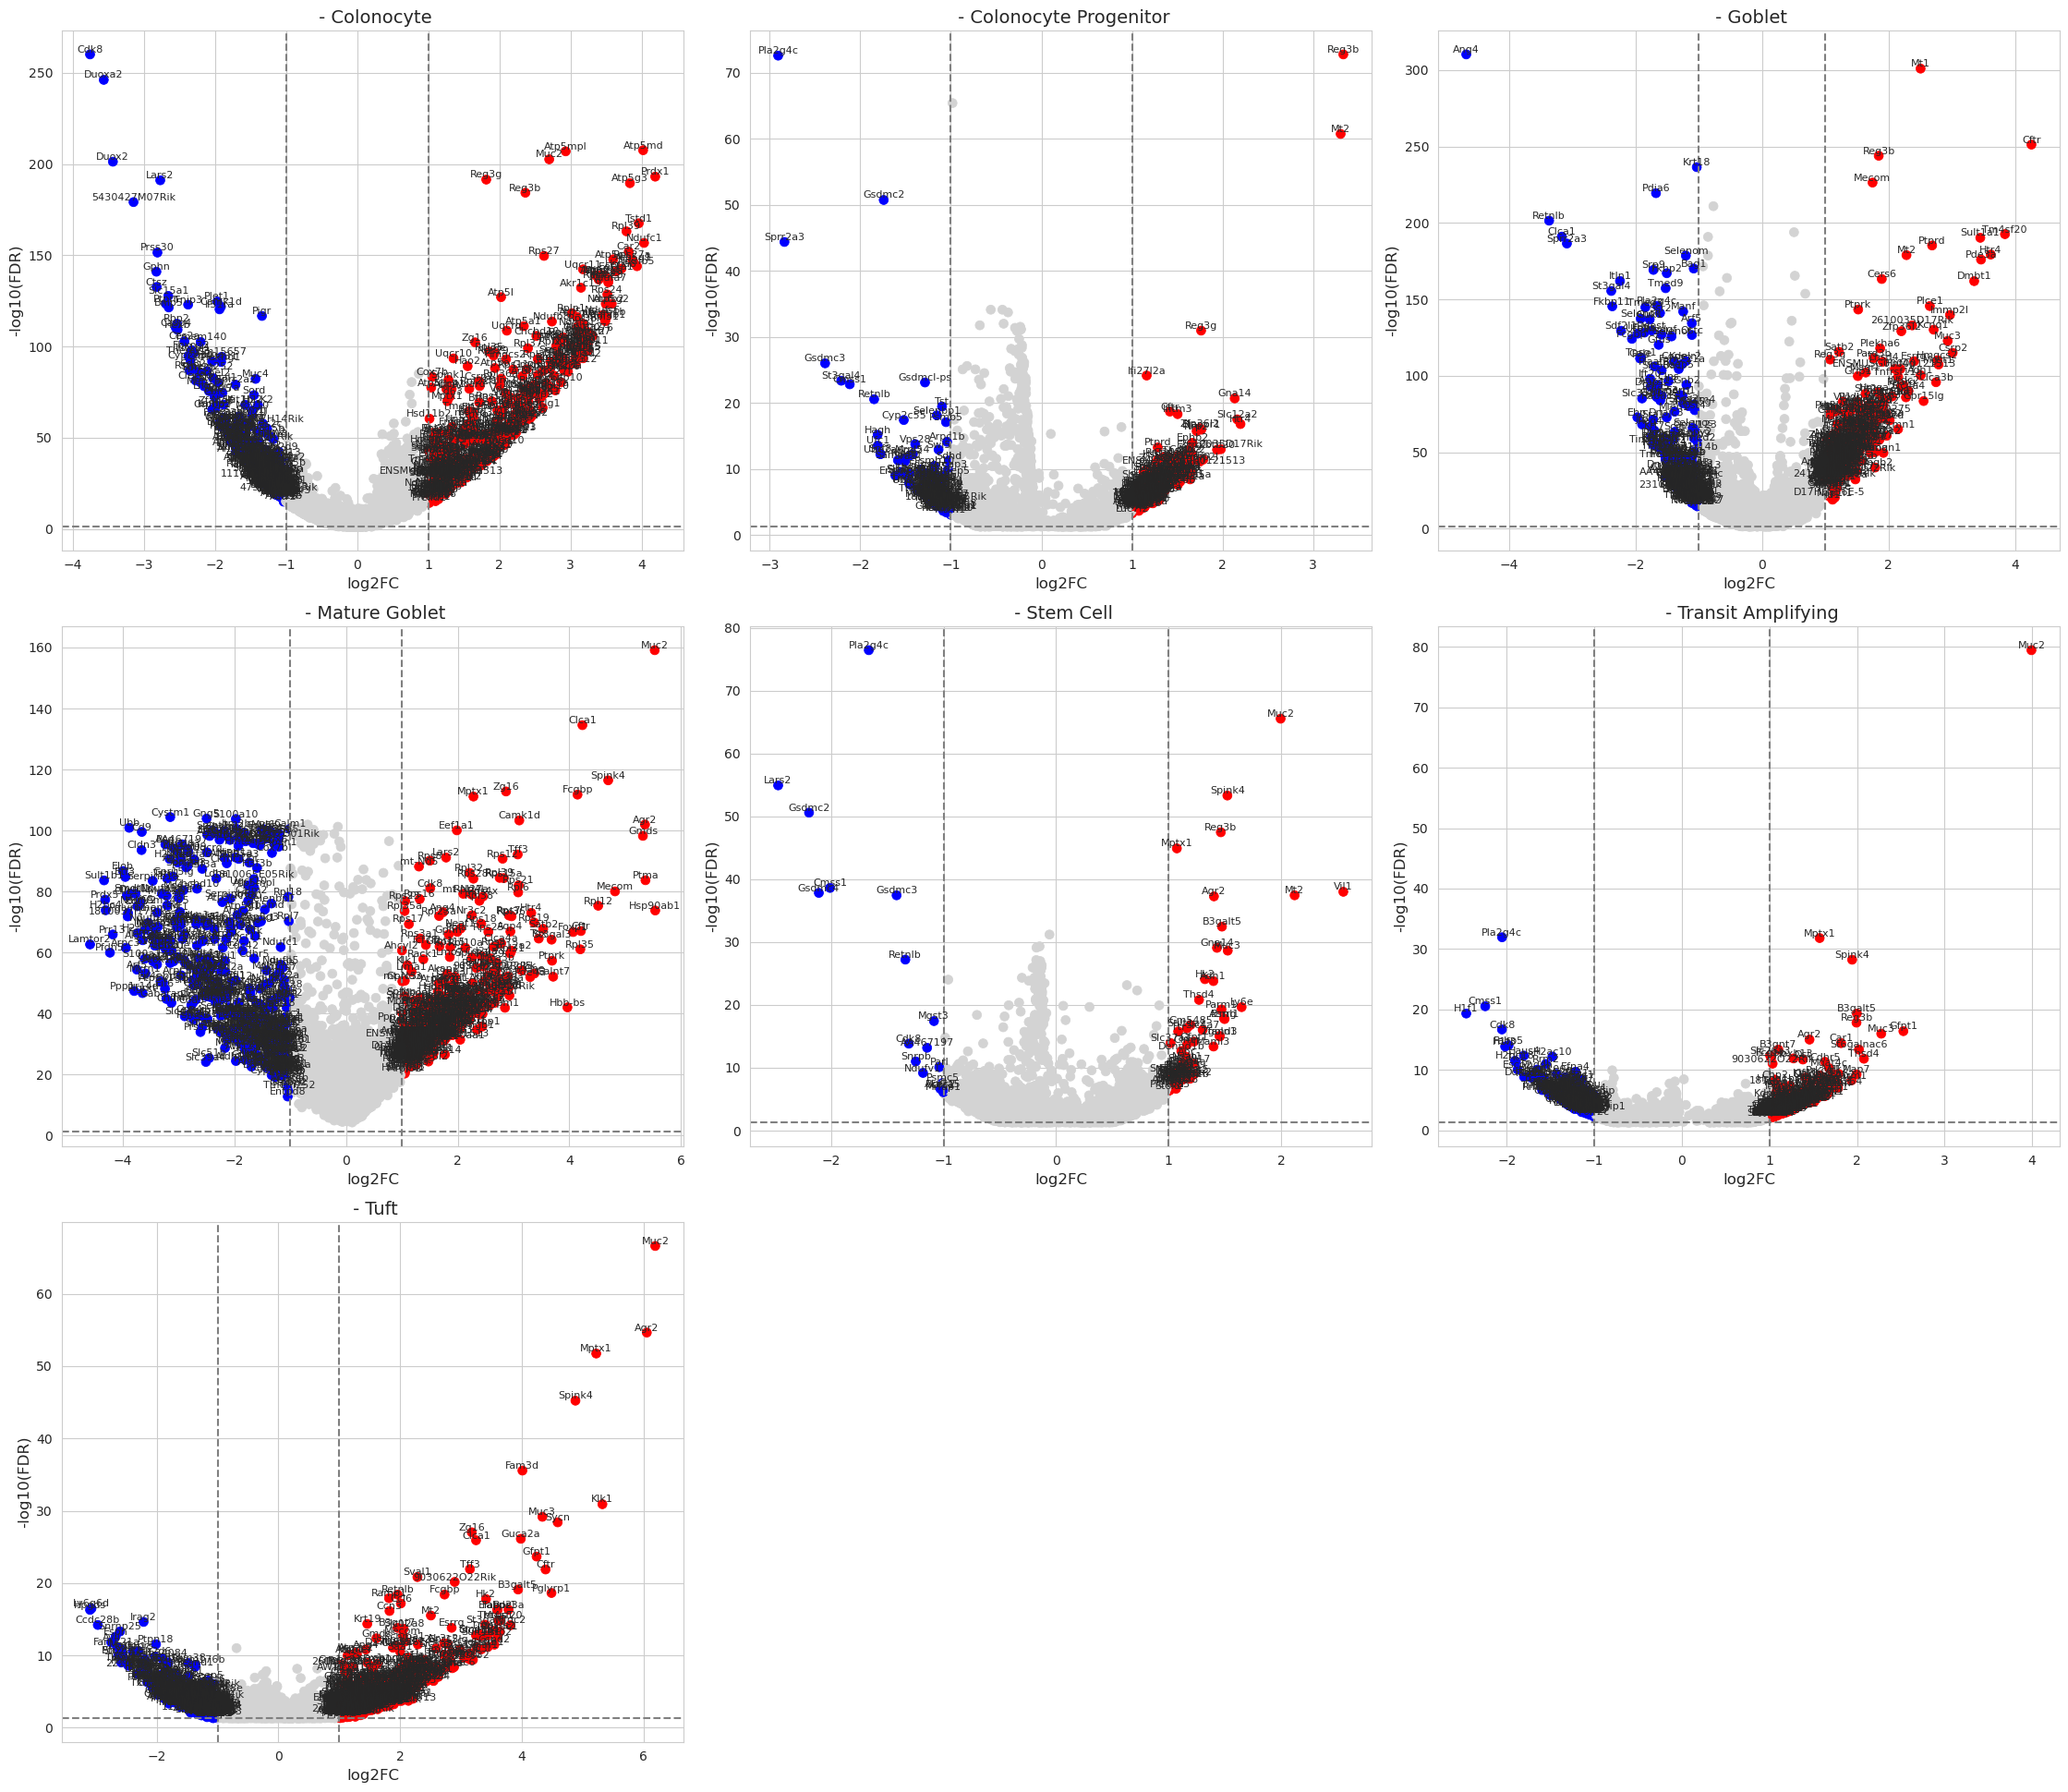

✅ Volcano plots salvos em: volcano_mast_HCar.png


In [ ]:
plot_volcano_mast_grid(
    df_result=combined_df_bm,
    fdr_cutoff=0.05,
    logfc_cutoff=1.0,
    title_prefix="",
    celltype_col='celltype_annotation_epithelial',
    output_file="volcano_mast.png"
)

### DEGs Bars

In [ ]:
def plot_mast_degs_by_celltype_grid(
    df_result,
    fdr_cutoff=0.05,
    logfc_cutoff=1.0,
    top_n=15,
    celltype_col='manual_celltype_annotation',
    title_prefix="Top DEGs",
    output_file="mast_degs_by_celltype.png"
):
    """
    Plot DEG barplots per cell type, organized in a grid layout (3 panels per row),
    and save all plots into a single PNG file.

    Parameters:
    ----------
    df_result : pd.DataFrame
        DataFrame containing DEG results with the columns
        ['primerid', 'coef', 'FDR', celltype_col].
    fdr_cutoff : float
        Maximum allowed FDR for a gene to be considered significant.
    logfc_cutoff : float
        Minimum absolute log2 fold-change required.
    top_n : int
        Number of top DEGs to display per cell type (ranked by FDR).
    celltype_col : str
        Column in df_result identifying the cell type.
    title_prefix : str
        Prefix used in the title of each subplot.
    output_file : str
        Name of the output PNG file.
    """

    # Check that required columns are present
    required_cols = {'primerid', 'coef', 'FDR', celltype_col}
    if not required_cols.issubset(df_result.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_cols}")
    
    # Group results by cell type and apply significance filters
    filtered_groups = {}
    for celltype, df_sub in df_result.groupby(celltype_col):
        df = df_sub.copy().dropna()
        df = df[df["FDR"] < fdr_cutoff]
        df = df[abs(df["coef"]) > logfc_cutoff]
        df = df.sort_values("FDR").head(top_n)
        if not df.empty:
            filtered_groups[celltype] = df

    # Stop if no cell type has significant DEGs after filtering
    if not filtered_groups:
        print("⚠️ No cell type contains significant DEGs with the selected filters.")
        return

    # Define grid layout (3 plots per row)
    n_panels = len(filtered_groups)
    n_cols = 3
    n_rows = math.ceil(n_panels / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    # Disable unused axes
    for ax in axes[n_panels:]:
        ax.axis('off')

    # Plot one barplot per cell type
    for i, (celltype, df) in enumerate(filtered_groups.items()):
        sns.barplot(
            x="coef",
            y="primerid",
            data=df,
            ax=axes[i]
        )
        axes[i].axvline(0, color='gray', linestyle='--')
        axes[i].set_xlabel("log2FC")
        axes[i].set_ylabel("Gene")
        axes[i].set_title(f"{title_prefix} - {celltype}")

    # Final layout adjustments, save and show
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

    print(f"✅ Plots exported to: {output_file}")


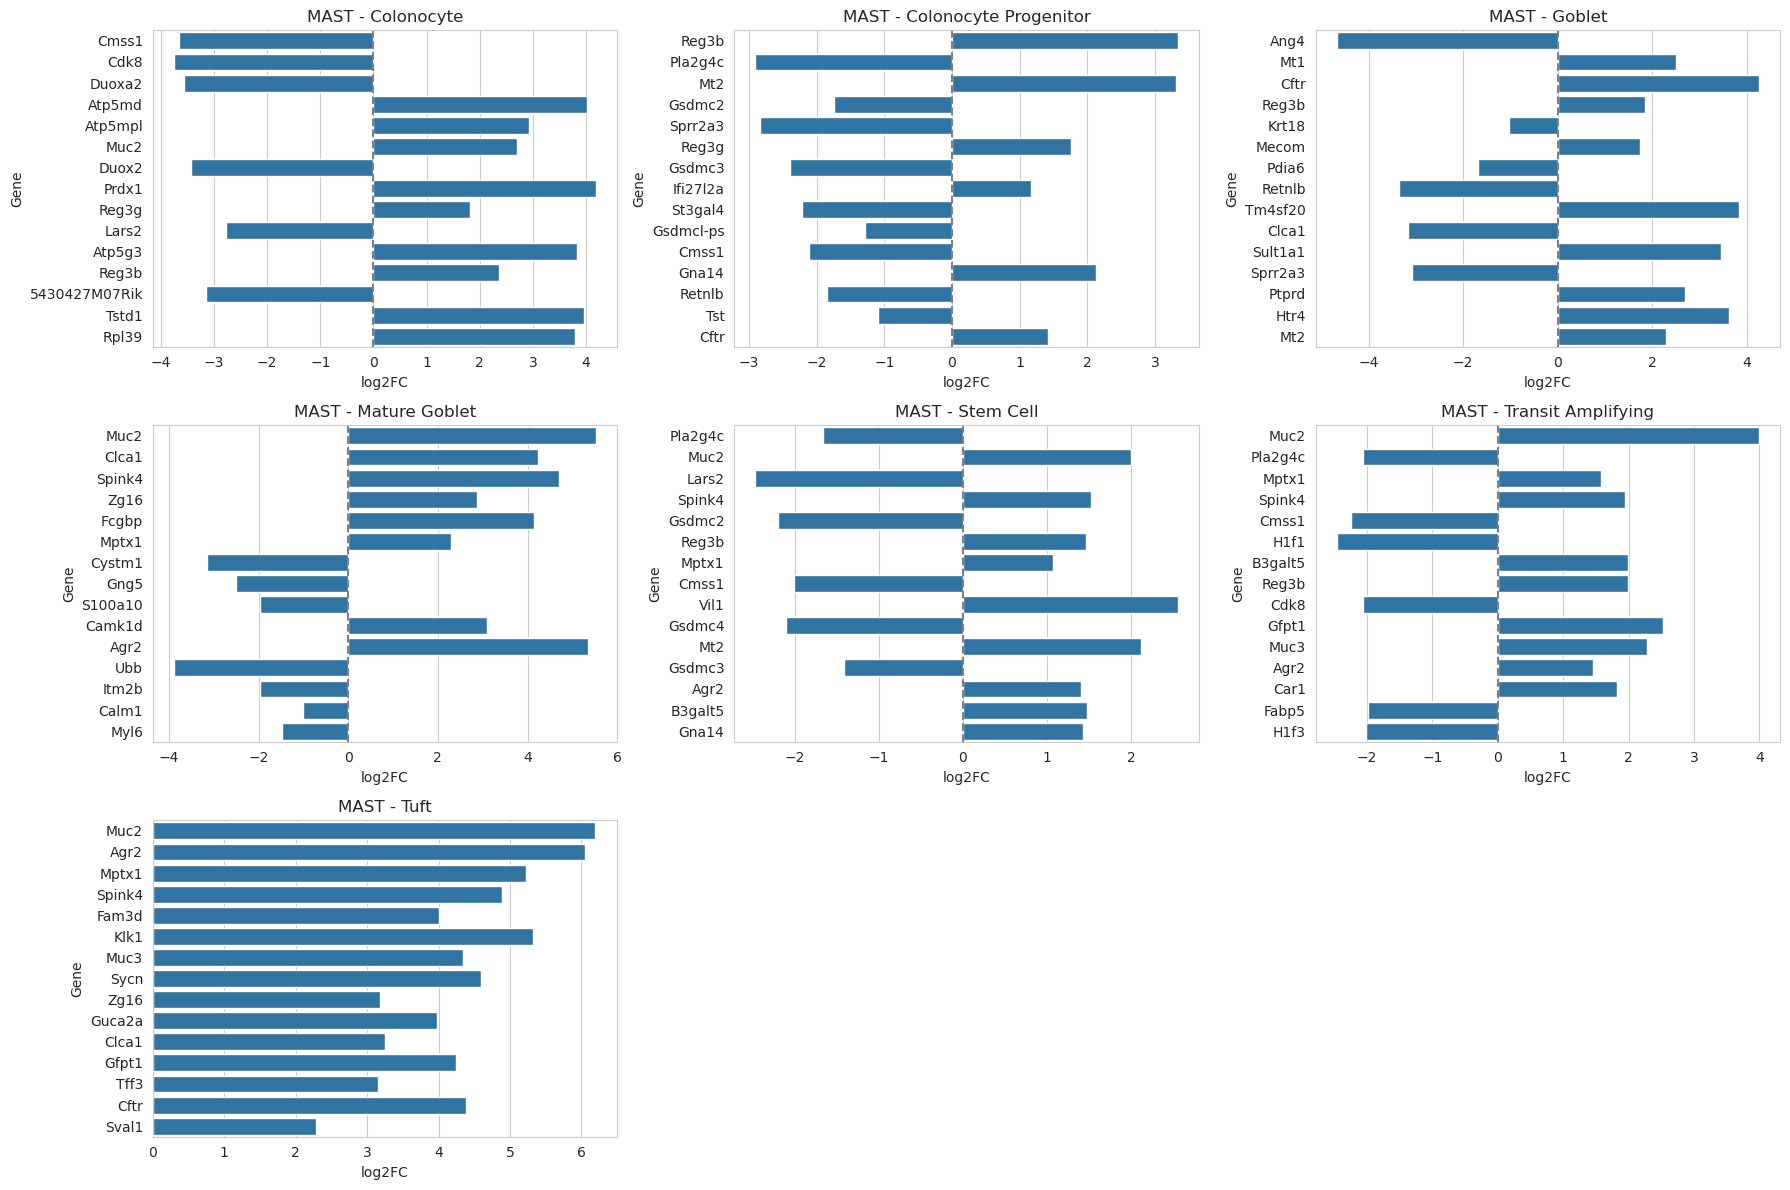

✅ Gráficos exportados para: ./mast_degs_Hcar.png


In [34]:
plot_mast_degs_by_celltype_grid(
    df_result=combined_df,       # seu DataFrame
    fdr_cutoff=0.05,
    logfc_cutoff=1.0,
    top_n=15,
    celltype_col='celltype_annotation_epithelial',
    title_prefix="MAST",
    output_file="./mast_degs_Hcar.png"
)

### Heatmap

In [ ]:
def plot_heatmap_top_degs(df_result,
                          top_n=20,
                          value_col="coef",
                          celltype_col="manual_celltype_annotation",
                          output_file="heatmap_top_degs.png",
                          title="Top DEGs por tipo celular"):
    """
    Generate a heatmap showing the top differentially expressed genes (DEGs)
    per cell type based on log2 fold change.

    Parameters:
    ----------
    df_result : pd.DataFrame
        DataFrame containing DEG results. It must include the columns
        ['primerid', value_col, celltype_col, 'FDR'].
    top_n : int
        Number of top genes to select per cell type (ranked by lowest FDR).
    value_col : str
        Column used as the heatmap value (e.g. 'coef' for log2FC).
    celltype_col : str
        Column identifying the cell type.
    output_file : str
        Path where the heatmap image will be saved.
    title : str
        Title of the heatmap.
    """

    # Select the top N genes per cell type based on smallest FDR
    top_degs = (
        df_result
        .sort_values("FDR")
        .groupby(celltype_col)
        .head(top_n)
    )

    # Get the unique list of genes appearing in the top DEG sets
    top_genes = top_degs["primerid"].unique()

    # Build a gene x cell type matrix using the selected value column (e.g. log2FC)
    pivot_df = (
        df_result[df_result["primerid"].isin(top_genes)]
        .pivot(index="primerid", columns=celltype_col, values=value_col)
    )

    # Order genes by the maximum absolute log2FC across cell types
    # (genes with strongest effects appear first)
    gene_order = (
        pivot_df.abs()
        .max(axis=1)
        .sort_values(ascending=False)
        .index
    )
    pivot_df = pivot_df.loc[gene_order]

    # Plot the heatmap
    plt.figure(figsize=(1.8 * len(pivot_df.columns), 0.3 * len(pivot_df)))
    sns.heatmap(
        pivot_df,
        cmap="bwr",              # blue-white-red colormap for up/down regulation
        center=0,                # center at zero log2FC
        linewidths=0.5,
        linecolor="lightgray",
        cbar_kws={"label": "log2FC"},
        xticklabels=True,
        yticklabels=True
    )

    # Formatting and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Cell type", fontsize=12)
    plt.ylabel("Gene", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(fontsize=8)

    # Final layout, save to file, and display
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()


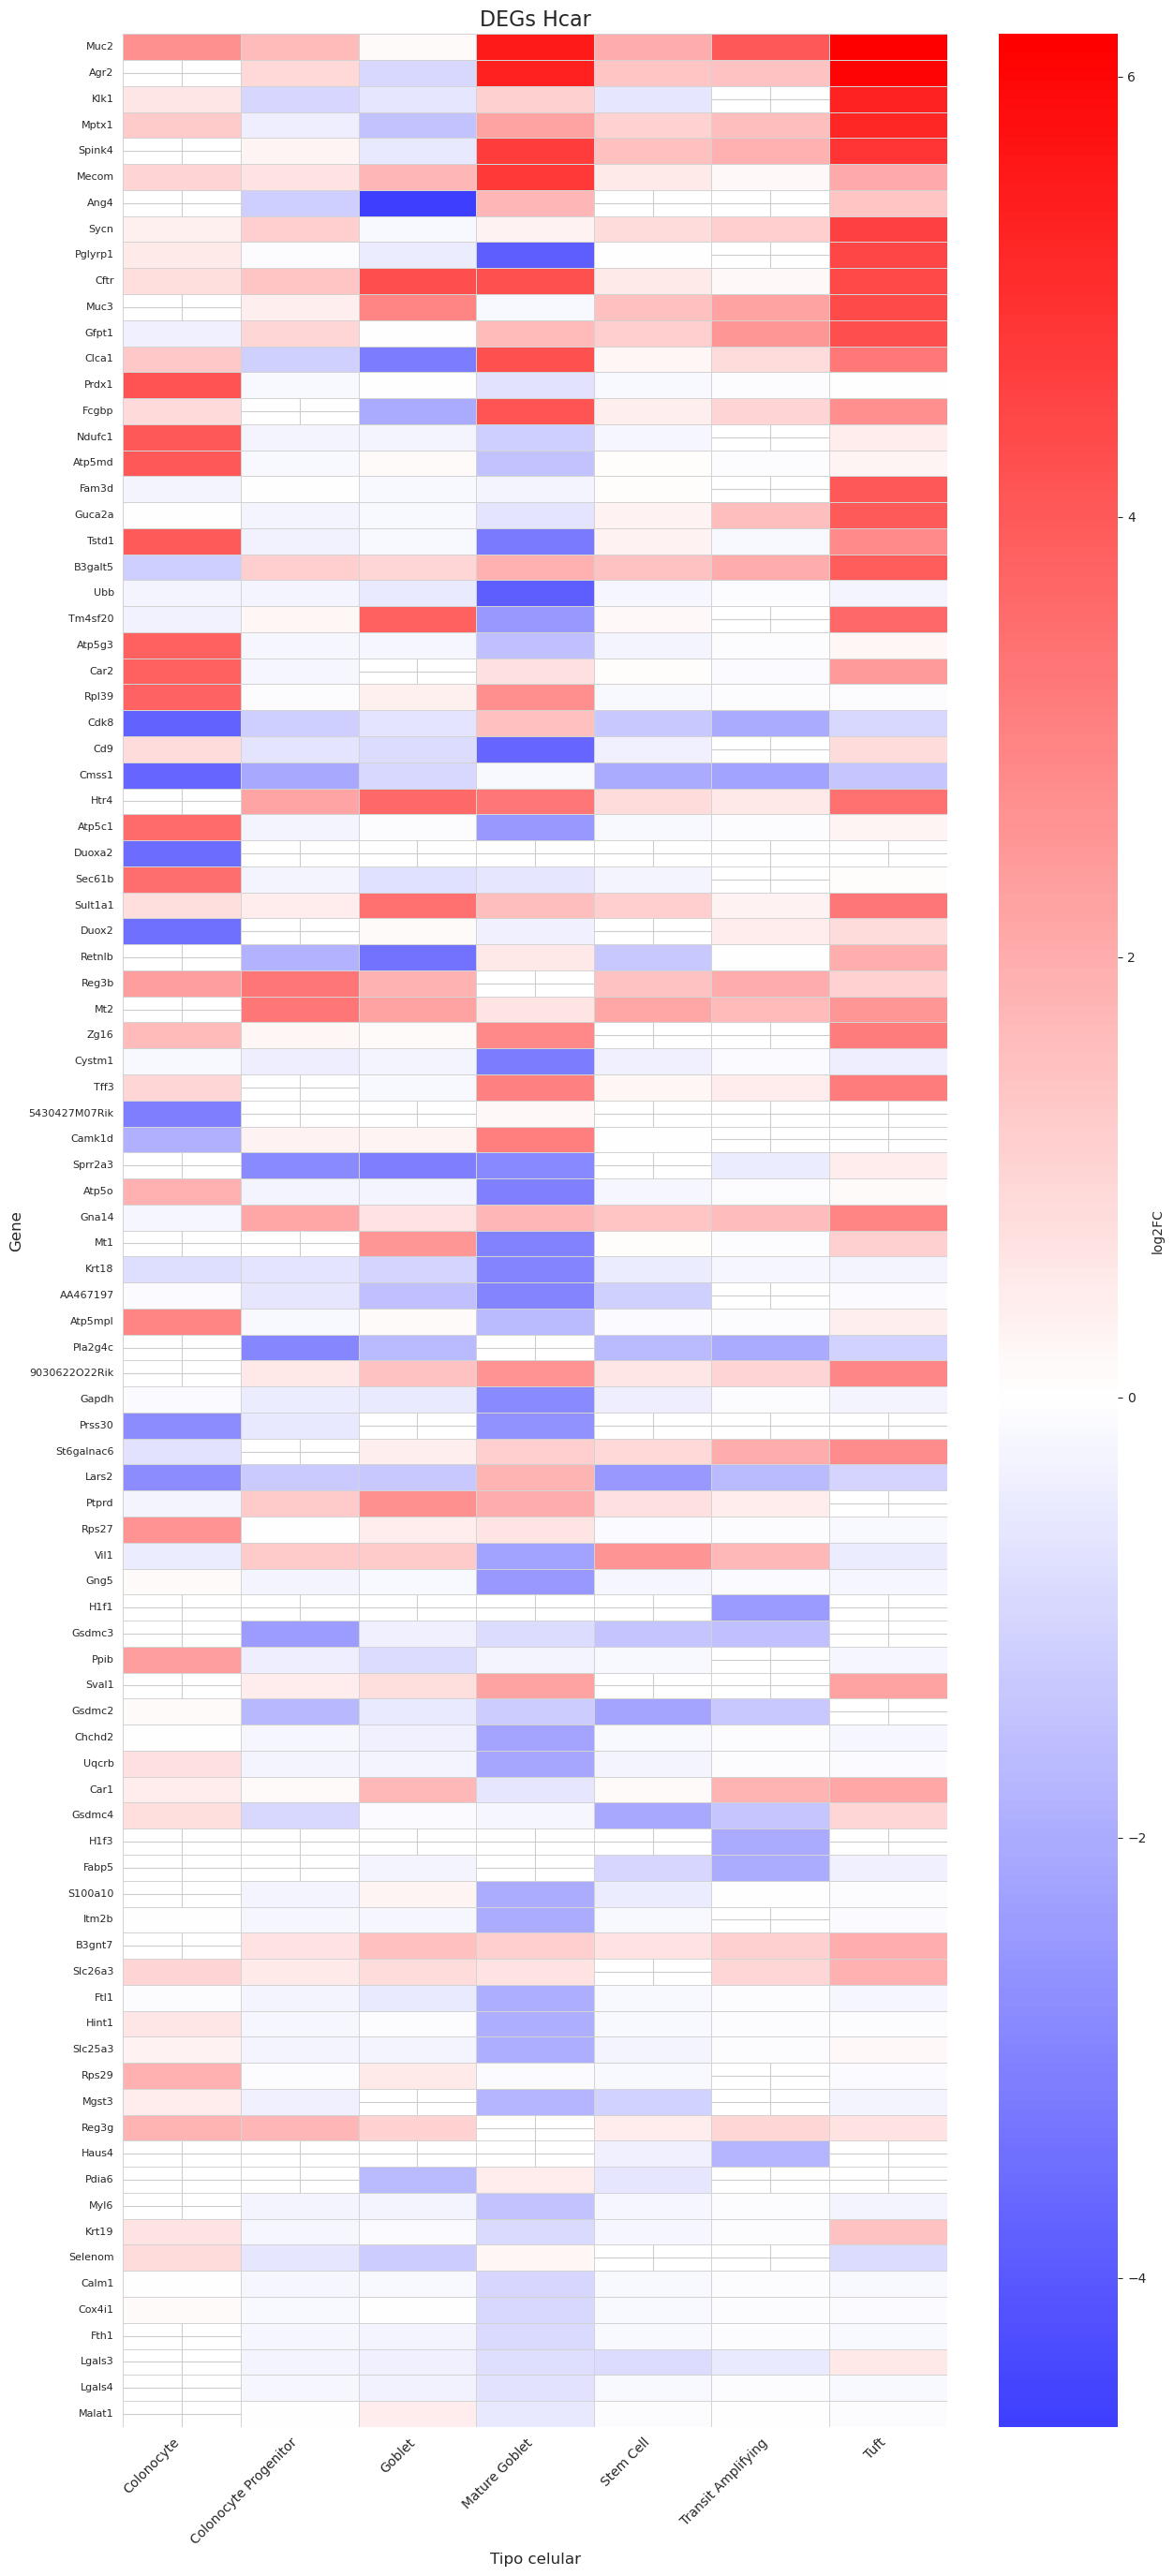

In [36]:
plot_heatmap_top_degs(df_result=combined_df, 
                      title="DEGs Hcar",
                      top_n=20,
                      celltype_col='celltype_annotation_epithelial',
                      output_file="./heatmap_Hcar")
